In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import geopandas
import contextily as cx
import matplotlib.pyplot as plt
import pickle
from shapely.geometry import Polygon
from utils import *
from region import Region
import shapely.geometry
import pandas as pd
import json

In [2]:
bounding_box = dict(
    Cairo=dict(box=[(30.4, 30.8),  (29.7, 31.8)]),
    Johannesburg=dict(box=[(-25.7, 27.7),  (-26.6, 28.5)]),
    Adana=dict(box=[(37.07143800485324, 35.17329182281017),  (36.91227725278698, 35.51638118905048)]),
    Ordu=dict(box=[(41.02005066750512, 37.859763930345395),  (40.922495635935796, 38.03387755848272)]),
    Trabzon=dict(box=[(41.021005197945385, 39.65238569404653),  (40.95879910380294, 39.80587291303715)]),
    Manisa=dict(box=[(38.69341901846549, 27.27799521554712),  (38.5893040428113, 27.491450649299416)]),
)

In [3]:
with open('bounding_box.json', 'w') as outfile:
    json.dump(bounding_box, outfile, sort_keys=True, indent=4,
                                separators=(',', ':'), ensure_ascii=False)

In [4]:
bounding_box = json.load(open('bounding_box.json'))
deg = 0.5

In [5]:
tk_cen_path = os.path.join("data","census","tk_summary.xlsx")
za_cen_path = os.path.join("data","census","za_summary.xlsx")
eg_cen_path = os.path.join("data","census","eg_summary.xlsx")

In [6]:
tk_cen = pd.read_excel(tk_cen_path, "mean")
za_cen = pd.read_excel(za_cen_path, "mean")
eg_cen = pd.read_excel(eg_cen_path, "mean")
tk_cen = tk_cen.groupby(["region","city","year"]).mean().reset_index()
# we only take the most recent year
tk_cen = tk_cen.groupby(["region","city"], sort=False)['year'].max().reset_index().merge(tk_cen, on=["region","city","year"])
eg_cen = eg_cen.groupby(["region","city"], sort=False)['year'].max().reset_index().merge(eg_cen, on=["region","city","year"])

# tk_cen.loc[tk_cen["city"]=='Altınordu', "city"] = "Merkez"
# tk_cen.loc[tk_cen["city"]=='Ortahisar', "city"] = "Merkez"
tk_cen.loc[tk_cen["city"]=='Yunusemre', "city"] = "Merkez"
za_cen = za_cen.groupby(["region","city","year"]).mean().reset_index()
eg_cen = eg_cen.groupby(["region","city","year"]).mean().reset_index()

In [10]:
Ordu = pickle.load(open(os.path.join("data","Ordu.pkl"),"rb"))
Trabzon = pickle.load(open(os.path.join("data","Trabzon.pkl"),"rb"))
Adana = pickle.load(open(os.path.join("data","Adana.pkl"),"rb"))
Manisa = pickle.load(open(os.path.join("data","Manisa.pkl"),"rb"))
Johannesburg = pickle.load(open(os.path.join("data","Johannesburg.pkl"),"rb"))
Cairo = pickle.load(open(os.path.join("data","Cairo.pkl"),"rb"))

In [30]:
city = "Johannesburg"
DF = pickle.load(open(os.path.join("data",f"{city}.pkl"),"rb"))
df = DF.house.to_frame( name="geometry")
df = df.to_crs("EPSG:3395")  
df["density"]=1 
df["area"]=df.area
df.to_pickle(f"{city}.pkl")
df.to_file(f"{city}.json", driver="GeoJSON")  

In [8]:
lcz_path = os.path.join ('data','lcz','lcz_filter_v1.tif')

In [9]:
cities = dict(
    Cario = dict(
        bounding_box= bounding_box["Cairo"]["box"],
        level = "NAME_2",
        name = "Cario",
        df = Cairo,
        census = eg_cen,
    ),
    Johannesburg = dict(
        bounding_box= bounding_box["Johannesburg"]["box"],
        level = "NAME_2",
        name = "Johannesburg",
        df = Johannesburg,
        census = za_cen,
    ),
    Adana = dict(
        bounding_box= bounding_box["Adana"]["box"],
        level = "NAME_2",
        name = "Adana",
        df = Adana,
        census = tk_cen,
    ),
    Ordu = dict(
        bounding_box= bounding_box["Ordu"]["box"],
        level = "NAME_2",
        name = "Ordu",
        df = Ordu,
        census = tk_cen,
    ),
    Manisa = dict(
        bounding_box= bounding_box["Manisa"]["box"],
        level = "NAME_2",
        name = "Manisa",
        df = Manisa,
        census = tk_cen,
    ),
    Trabzon = dict(
        bounding_box= bounding_box["Trabzon"]["box"],
        level = "NAME_2",
        name = "Trabzon",
        df = Trabzon,
        census = tk_cen,
    ),
)

Cario
Johannesburg
Adana
Ordu
Manisa
Trabzon


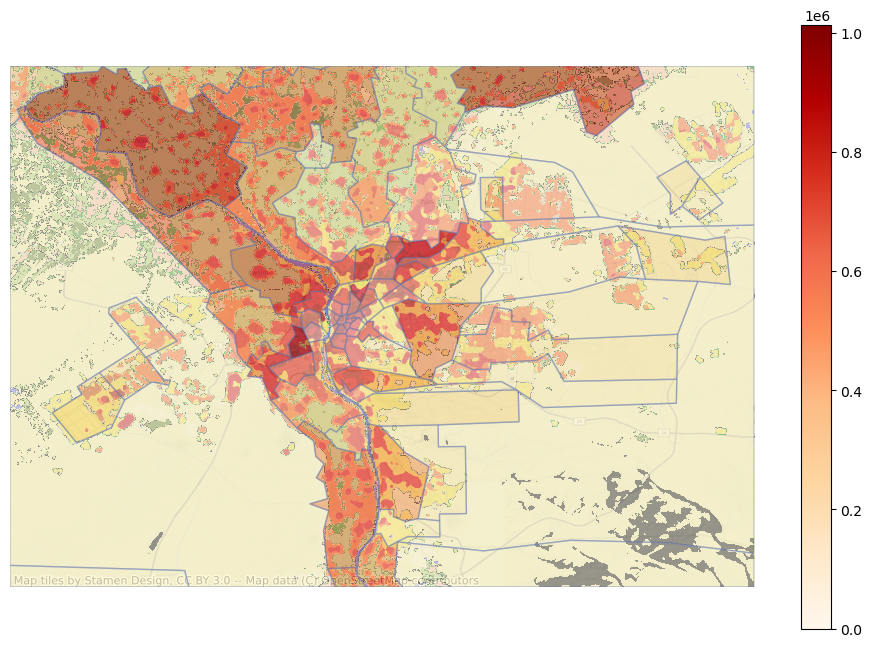

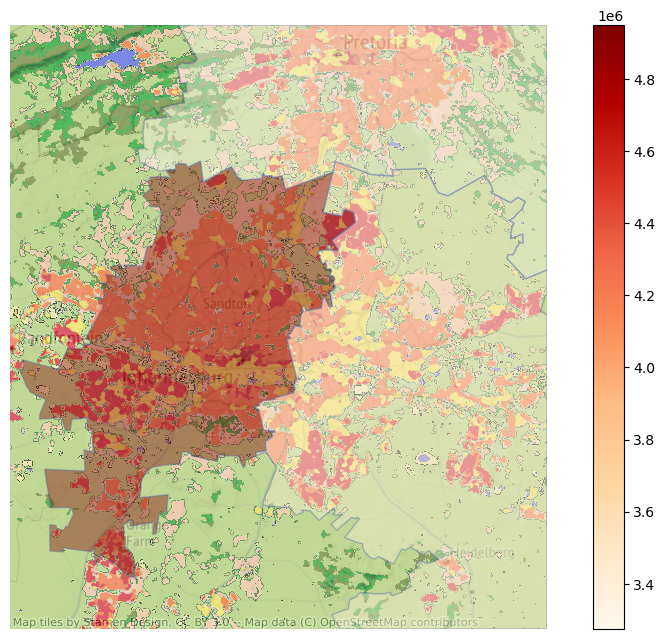

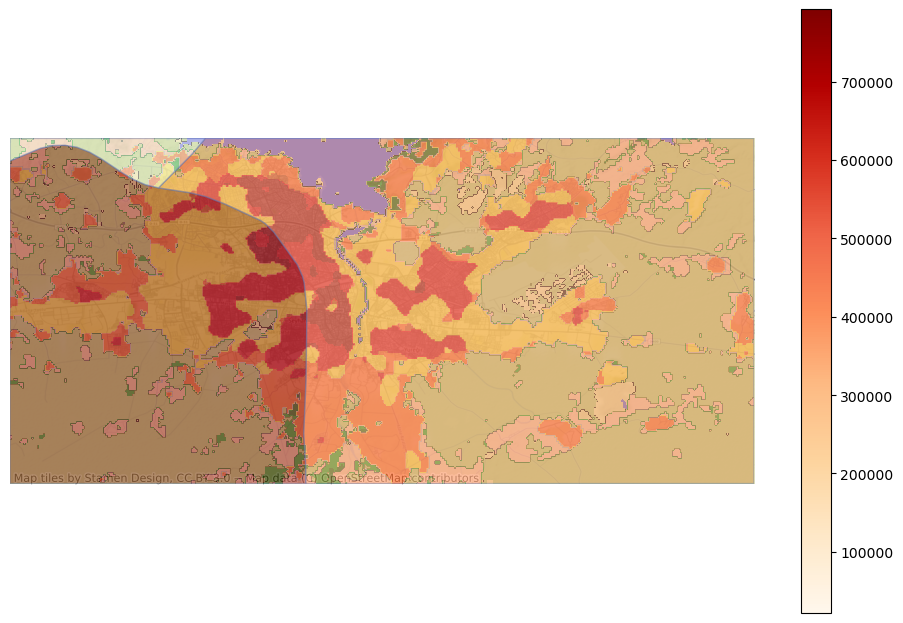

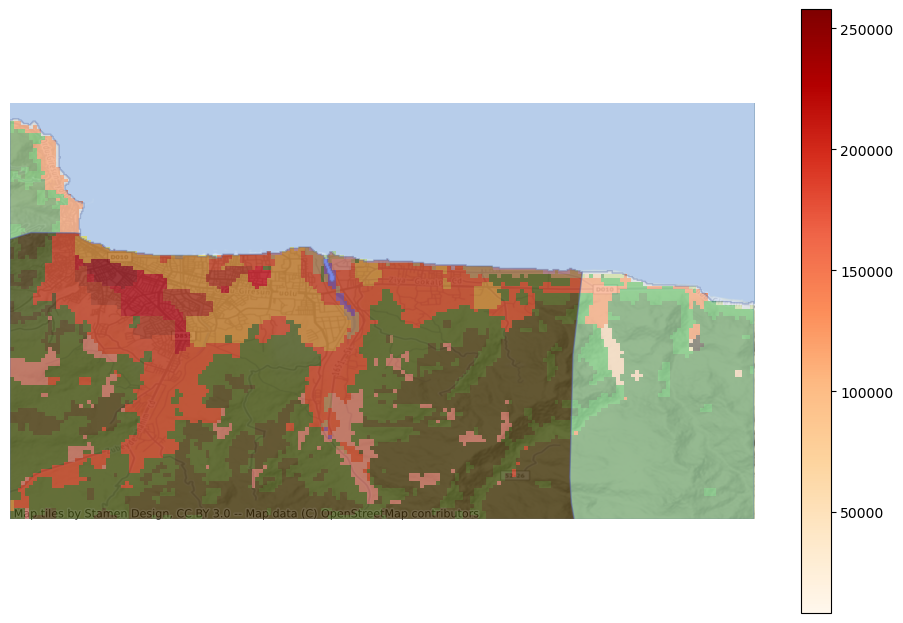

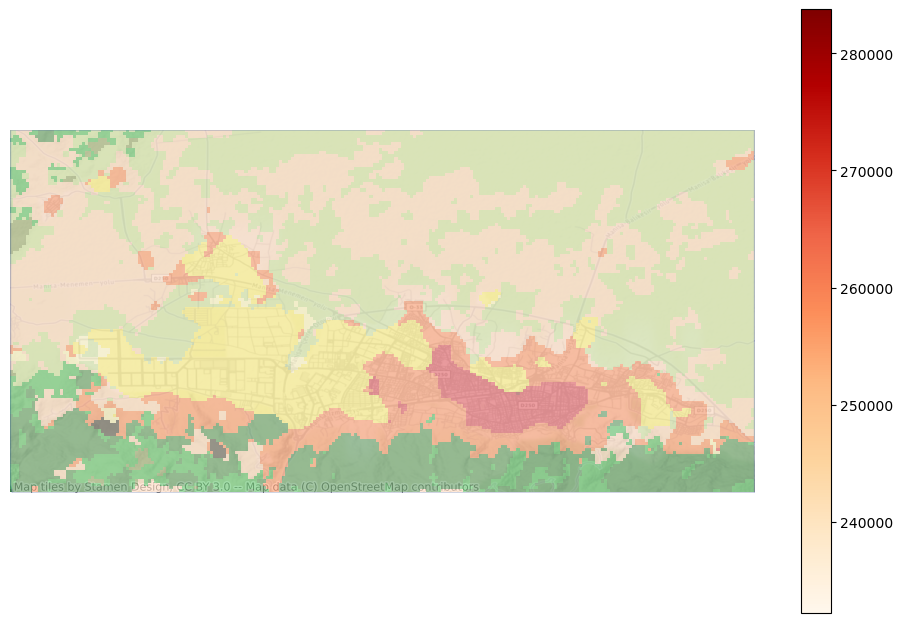

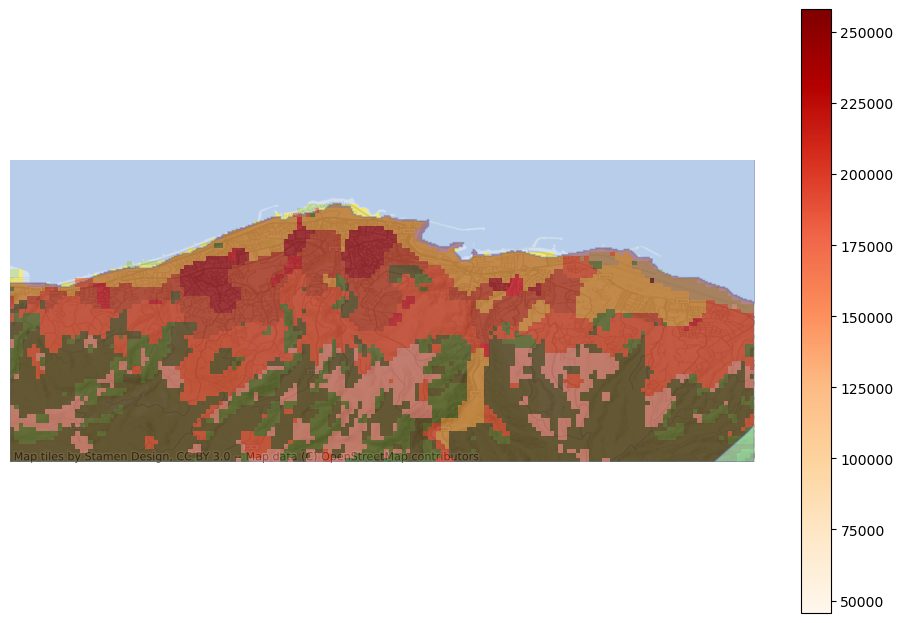

In [11]:
for index, (key, val) in enumerate(cities.items()):
    print(key)
    curr = Region(val["df"].df, level = val["level"], name=val["name"], lcz_path=lcz_path)
    (lat_tl, lon_tl), (lat_br, lon_br) = val["bounding_box"]
    curr.inner_box.create_box([(lat_tl, lon_tl), (lat_br, lon_br)])
    curr.outer_box.create_box([(lat_tl+deg, lon_tl-deg), (lat_br-deg, lon_br+deg)])
    curr.inner_box.bound_census(val["census"],"city")
    curr.house = val["df"].house
    curr.create_map_static("population")
    # pickle.dump(curr, open(os.path.join("data",f"{key}_v1.pkl"),"wb"))

---